# Taxicab (tramcar) Problem --- Using PyMC3

(From Kevin Murphy: Machine Learning: A Probabalistic Perspective; Chapter 3: Question: 3.10) 

 By Perry Grossman

Using example code from:

### Solving the Bayesian German Tank problem with PyMC and PyStan19 Dec 2015

Source: http://isaacslavitt.com/2015/12/19/german-tank-problem-with-pymc-and-pystan/

PG: Using Anaconda Python 3.5 on Ubuntu 16.04

Solving it:   
The Wikipedia article explains both the frequentist and Bayesian approaches, and the example in the Sampyl docs does a good job of explaining the setup for the Bayesian version. Here's the gist: we want to know the posterior probability of the number of tanks 
N
, given data 
D
 on which tank serial numbers have been observed so far:

P
(
N
∣
D
)
∝
P
(
D
∣
N
)
P
(
N
)  
The right-hand side breaks down into two parts. The likelihood of observing all the serial numbers we saw is the product of the individual probabilities 
D
i
 given the actual number of tanks in existence 
N
:

P
(
D
∣
N
)
=
∏
i
 
P
(
D
i
∣
N
)
P
(
D
i
∣
N
)
∼
D
i
s
c
r
e
t
e
U
n
i
f
o
r
m
(
D
,
m
i
n
=
0
,
m
a
x
=
N
)  
The prior over 
N
, which we know must be at least as high as the highest serial number we observed (call that 
m
) but could be much higher:

P
(
N
)
∼
D
i
s
c
r
e
t
e
U
n
i
f
o
r
m
(
N
,
m
i
n
=
m
,
m
a
x
=
s
o
m
e 
b
i
g 
n
u
m
b
e
r
)  
The MCMC strategy will be to try a bunch of different values for 
N
, see how likely they are (compared to one another), and assemble the results of the sampling into a distribution over 
N
. The solution implementation with Sampyl was interesting, but the project is still early so I wanted to give it a shot using two other popular MCMC libraries.

---

PG: First repeat his work:

In [2]:
import numpy as np
import pymc3 as pm

# D: the data
y = np.array([10, 256, 202, 97])

model = pm.Model()
with model:
    
    # prior - P(N): N ~ uniform(max(y), 10000)
    # note: we use a large-ish number for the upper bound
    N = pm.DiscreteUniform("N", lower=y.max(), upper=10000)

    # likelihood - P(D|N): y ~ uniform(0, N)
    y_obs = pm.DiscreteUniform("y_obs", lower=0, upper=N, observed=y)

    # choose the sampling method - we have to use Metropolis-Hastings because
    # the variables are discrete
    step = pm.Metropolis()
    
    # we'll use four chains, and parallelize to four cores
    start = {"N": y.max()} # the highest number is a reasonable starting point
    trace = pm.sample(100000, step, start, chain=4, njobs=4)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]
Sampling 4 chains: 100%|██████████| 402000/402000 [01:20<00:00, 4994.62draws/s]
The number of effective samples is smaller than 10% for some parameters.


PG: I think the warning above is a concern statistically. For further review.

-----

PG: You might run into some Python packaging issues.   
(I am using Python3 in Anaconda, on Ubuntu 16.04)  
    
Conda update conda seems to have solved them for me.   
But here are some other resources in case you need them:


https://github.com/Theano/Theano/issues/6568

-----

In [6]:
# summarize the trace
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
N,381.981255,200.063709,1.49169,256.0,694.0,14835.428864,1.000339


His output also had:

I did not get the same output that he did here: http://isaacslavitt.com/2015/12/19/german-tank-problem-with-pymc-and-pystan/

(That might be due to differences in python/Anaconda/PYMC3 between what he used and what I am using)

So I tried to find the information this way:

In [7]:
pm.quantiles(trace)

{8: {'N': {2.5: 258, 25: 282, 50: 323, 75: 403, 97.5: 873}},
 9: {'N': {2.5: 258, 25: 280, 50: 323, 75: 406, 97.5: 913}},
 10: {'N': {2.5: 258, 25: 281, 50: 323, 75: 408, 97.5: 861}},
 11: {'N': {2.5: 257, 25: 280, 50: 321, 75: 403, 97.5: 837}}}

I guess this is similar; but perhaps I am getting 4 different outputs from the 4 jobs specified.

My median is 321-323.  
(His output might average them.)  
But  
873  
913  
816  
837  
averages to : 
859.75, not 862

(maybe his average is weighted?)

##### Plot with a burn in--- throwing away the first 10,000 samples

Why do we do a burn in?


"You create the parameter trace plots to make sure that your a priori distribution is well calibrated which is indicated by your parameters having sufficient state changes as the MCMC algorithm runs..."

Source: https://stats.stackexchange.com/questions/120936/why-we-need-trace-plot-for-mcmc-results

/home/perry/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


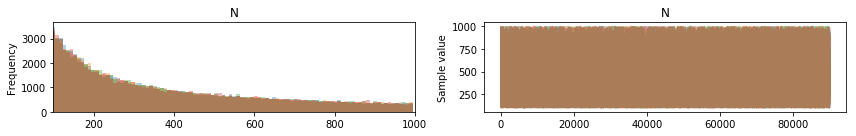

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

# plot the trace
burn_in = 10000  # throw away the first 10,000 samples
pm.traceplot(trace[burn_in:])
plt.show()

So the mean here was 384, and the median was 322.

## PG: Now let's try to apply the above advice to Exercise 3.10 Taxicab (tramcar) Problem

Exercise 3.10 Taxicab (tramcar) problem
Suppose you arrive in a new city and see a taxi numbered 100. How many taxis are there in this city? Let
us assume taxis are numbered sequentially as integers starting from 0, up to some unknown upper bound
θ. (We number taxis from 0 for simplicity; we can also count from 1 without changing the analysis.) Hence
the likelihood function is   
p(x) = U(0, θ)  
, the uniform distribution. The goal is to estimate θ. We will use
the Bayesian analysis from Exercise 3.9.  

a. Suppose we see one taxi numbered 100, so D = {100}, m = 100, N = 1. Using an (improper)
non-informative prior on θ of the form p(θ) = P a(θ|0, 0) ∝ 1/θ, what is the posterior p(θ|D)?  
b. Compute the posterior mean, mode and median number of taxis in the city, if such quantities exist.  
c. Rather than trying to compute a point estimate of the number of taxis, we can compute the predictive
density over the next taxicab number using  
p(D
|D, α) = 
p(D
|θ)p(θ|D, α)dθ = p(D
|β) (3.96)  
where α = (b, K)   
are the hyper-parameters,   
β = (c, N + K) 
are the updated hyper-parameters. 
Now
consider the case   
D = {m}, and D = {x}.   
Using Equation 3.95, write down an expression for  
p(x|D, α) (3.97)  

As above, use a non-informative prior b = K = 0.  

d. Use the predictive density formula to compute the probability that the next taxi you will see (say,
the next day) has number 100, 50 or 150, i.e., compute p(x = 100|D, α), p(x = 50|D, α), p(x =
150|D, α).  

e. Briefly describe (1-2 sentences) some ways we might make the model more accurate at prediction.

##### a. what is the posterior p(θ|D)? 

We are just seeing the number 100.

##### b. Compute the posterior mean, mode and median number of taxis in the city, if such quantities exist.

In [18]:
# D: the data
y = np.array([100])

model = pm.Model()
with model:
    
    # prior - P(N): N ~ uniform(max(y), 10000)
    # note: we use a large-ish number for the upper bound
    N = pm.DiscreteUniform("N", lower=y.max(), upper=10000)

    # likelihood - P(D|N): y ~ uniform(0, N)
    y_obs = pm.DiscreteUniform("y_obs", lower=0, upper=N, observed=y)

    # choose the sampling method - we have to use Metropolis-Hastings because
    # the variables are discrete
    step = pm.Metropolis()
    
    # we'll use four chains, and parallelize to four cores
    start = {"N": y.max()} # the highest number is a reasonable starting point
    trace = pm.sample(100000, step, start, chain=4, njobs=4)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]
Sampling 4 chains: 100%|██████████| 402000/402000 [01:25<00:00, 4701.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


There is some information on chaings versus job here:  
fonnesbeck (PYMC orginator)  
PyMC_devs  
Nov '17  
I’ve submitted a PR to improve the docstring for chains. It will select the higher of njobs or 2. Most of the time you will want to sample in parallel to accomodate Gelman-Rubin diagnostic calculation. So, when you set njobs to 1 there will still be 2 chains sampled, it will just occur in serial (unless you set chains to 1 as well).  

Note, however, when you ask for 1000 samples (by setting iterations=1000, you will get 1000 samples, it will just be broken out over however many chains are specified.  

https://discourse.pymc.io/t/specifying-the-number-of-chains-chains-vs-njobs/595/7

In [19]:
# summarize the trace
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
N,2168.725998,2509.401932,26.526212,100.0,7983.0,8168.582267,1.000179


The mean is 2,191 with an upper bound of 10,000

With this largare upper bound of 10,000, versus the 1,000 used by Allen Downey, we have a much higher estimated mean.

In [20]:
pm.quantiles(trace)

{8: {'N': {2.5: 114, 25: 330, 50: 1054, 75: 3258, 97.5: 8988}},
 9: {'N': {2.5: 113, 25: 323, 50: 1002, 75: 3243, 97.5: 8873}},
 10: {'N': {2.5: 113, 25: 311, 50: 962, 75: 3024, 97.5: 8928}},
 11: {'N': {2.5: 111, 25: 328, 50: 1030, 75: 3265, 97.5: 8963}}}

Median ranges from 962 to 1054

The mode should be 100, since there is only one observation.

---

##### Let's try it with 1000, as Allen Downey did:

In [21]:
# D: the data
y = np.array([100])

model = pm.Model()
with model:
    
    # prior - P(N): N ~ uniform(max(y), 1000)
    # note: we use a large-ish number for the upper bound
    N = pm.DiscreteUniform("N", lower=y.max(), upper=1000)

    # likelihood - P(D|N): y ~ uniform(0, N)
    y_obs = pm.DiscreteUniform("y_obs", lower=0, upper=N, observed=y)

    # choose the sampling method - we have to use Metropolis-Hastings because
    # the variables are discrete
    step = pm.Metropolis()
    
    # we'll use four chains, and parallelize to four cores
    start = {"N": y.max()} # the highest number is a reasonable starting point
    trace = pm.sample(100000, step, start, chain=4, njobs=4)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]
Sampling 4 chains: 100%|██████████| 402000/402000 [01:21<00:00, 4910.84draws/s]
The number of effective samples is smaller than 10% for some parameters.


PG: Im not sure if I should be changing these specifications with only 1 sample.  
        trace = pm.sample(100000, step, start, chain=4, njobs=4)

In particular, can I reduce this from 100,000 samples to make it run faster and still get a good result?

Need to do further reading on PYMC3, etc.

In [22]:
# summarize the trace
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
N,389.129127,249.248689,1.400003,100.0,891.0,34057.917877,1.00002


The mean is 389, which is in the same ballpark; but higher than the 333, using Allen Downey's code.

In [23]:
pm.quantiles(trace)

{8: {'N': {2.5: 105, 25: 177, 50: 311, 75: 554, 97.5: 941}},
 9: {'N': {2.5: 106, 25: 177, 50: 315, 75: 562, 97.5: 946}},
 10: {'N': {2.5: 106, 25: 176, 50: 315, 75: 564, 97.5: 944}},
 11: {'N': {2.5: 105, 25: 178, 50: 314, 75: 559, 97.5: 944}}}

The median is 311 to 315

Again, the mode should 100, for the one sample.

##### c. Rather than trying to compute a point estimate of the number of taxis, we can compute the predictive density over   the next taxicab number using
p(D |D, α) =  p(D |θ)p(θ|D, α)dθ = p(D |β) (3.96)  
where α = (b, K)
are the hyper-parameters,  
β = (c, N + K) are the updated hyper-parameters.     

Now consider the case  
D = {m}, and D = {x}.
Using Equation 3.95, write down an expression for  
p(x|D, α) (3.97)

As above, use a non-informative prior b = K = 0.

Start with this...

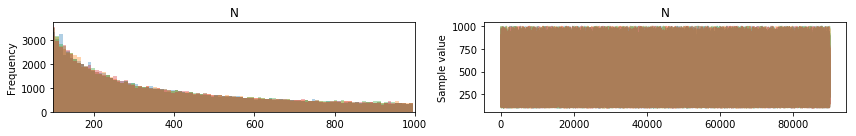

In [24]:
# plot the trace
burn_in = 10000  # throw away the first 10,000 samples
pm.traceplot(trace[burn_in:])
plt.show()

Then...?

##### d. Use the predictive density formula to compute the probability that the next taxi you will see (say, the next day) has number 100, 50 or 150, i.e., compute
p(x = 100|D, α), p(x = 50|D, α), p(x = 150|D, α).

##### e. Briefly describe (1-2 sentences) some ways we might make the model more accurate at prediction.